In [3]:
!pip install finnhub-python

In [4]:
from time import sleep
from datetime import datetime

import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import finnhub

# Hyperparameters
Hyperparameter | Description
---------------|--------------
pred_delta_t|Working days from current period to predict (i.e. classifying the up/down trend delta_t days from today)
thresh_vec|Vector of non-softmaxed weak, fair, and strong sell or buy discrete probability categories (i.e. stock A on day t0 classifies as a strong sell after delta_t days because it decreases by 26.3%, relative to the price of day t0
SML_period_lengths|Vector of WORKING-day lengths for short, medium, and long indicator periods
Start timestamp|Earliest historical quote date for the model


In [5]:
pred_delta_t = 15   # measured in working days

# NOTE: Change threshold for 'Fair' back to 0.04 after testing with fewer output labels
thresh_vec = {0.04: 'Fair', 0.10: 'Moderate', 0.16: 'Strong'}    # inclusive percentage thresholds for confidence in buying and selling
sml_period_lengths = [10, 25, 50]    # each element is measured in [working days]

start_date = int(datetime(2011, 12, 31).timestamp())   # Dec. 31, 2011
end_date = int(datetime(2021, 3, 19).timestamp())   # Mar. 18, 2021

api_key = 'c1b6o8v48v6rcdq9ug4g'
api_call_time_buffer = 1     # in seconds. Limit is 60 calls a minute
fc = finnhub.Client(api_key='c1b6o8v48v6rcdq9ug4g')

# Dev Notes
## Alpha Vantage
Sector requests: https://www.alphavantage.co/query?function=SECTOR&apikey=S7A5K9FH46EIZUQ4  
Documentation: https://www.alphavantage.co/documentation/  
Client github: https://github.com/RomelTorres/alpha_vantage/blob/develop/alpha_vantage/techindicators.py

## Finnhub
Documentation: https://finnhub.io/docs/api/recommendation-trends  
Technical Indicator API: https://docs.google.com/spreadsheets/d/1ylUvKHVYN2E87WdwIza8ROaCpd48ggEl1k5i5SgA29k/edit#gid=0  
Client github: https://github.com/Finnhub-Stock-API/finnhub-python/blob/5f3369e916dde0d5cc34c8d3504feac00781b055/finnhub/client.py

## Miscellaneous
How to import CSV files in Google Colab: https://www.geeksforgeeks.org/ways-to-import-csv-files-in-google-colab/

# Data Collection and Output Calculation

In [7]:
# Market index static input features (same for every company on the same date)
url = 'https://github.com/aragorn-w/Stock-Purchase-Action-Profit-Classifier/raw/main/market-index-data/Nasdaq-Composite.csv'
nasdaq = pd.read_csv(url)

url = 'https://github.com/aragorn-w/Stock-Purchase-Action-Profit-Classifier/raw/main/market-index-data/Russell-2000.csv'
russell = pd.read_csv(url)

url = 'https://github.com/aragorn-w/Stock-Purchase-Action-Profit-Classifier/raw/main/market-index-data/SP-500.csv'
sp500 = pd.read_csv(url)
sp500 = sp500.iloc[::-1]
sp500.reset_index(inplace=True, drop=True)
sp500.drop(sp500.tail(1).index, inplace=True)
sp500.columns = ['Date', 'Open', 'High', 'Low', 'Close'] # cleans up the column names

djia_dict = fc.stock_candles('DJIA', 'D', start_date, end_date)
dowjones = pd.DataFrame.from_dict(djia_dict)
dowjones.columns = ['Close', 'High', 'Low', 'Open', 'Status', 'UNIX Time', 'Volume']

market_columns = {}
sml_period_lengths = [10, 25, 50]    # each element is measured in [working days]
market_indices = {'NasdaqComposite': nasdaq, 'Russell2000': russell, 'SP500': sp500, 'DowJones': dowjones}
for market_name, market_index in market_indices.items():
    market_columns[market_name + '_Close'] = market_index['Close']
    if market_name != 'SP500':
        market_columns[market_name + '_Volume'] = market_index['Volume']
    for timeperiod in sml_period_lengths:
        market_columns[market_name + f'_%change_after_{timeperiod}'] = market_index['Close'].pct_change(periods=timeperiod)
market_df = pd.concat(market_columns.values(), axis=1, copy=False)
market_df.columns = market_columns.keys()
market_df.fillna(value=market_df.mean(), inplace=True)

In [20]:
# Symbols for Training
# NOTE: (remember to avoid survivorship bias)
training_symbols = ['LSCC', 'A', 'AMZN', 'FB', 'CSCO', 'AAPL', 'MSFT', 'GOOGL', 'ORCL', 'SAP', 'IBM']

# Input features
# timeperiod_tis is only for features with only ONE timeperiod parameter
timeperiod_tis = list(set(['sma', 'ema', 'adx', 'rsi', 'cci', 'wma', 'dema', 'tema', 'trima', 
                  'kama', 't3', 'willr', 'adxr', 'mom', 'roc', 'rocr', 'aroon', 'aroonosc', 
                  'mfi', 'trix', 'dx', 'minusdi', 'plusdi', 'minusdm', 'plusdm', 'midprice',
                  'atr', 'natr']))
# no_timeperiod_ti_columns is for all other features without the criteria of timeperiod_tis
no_timeperiod_ti_columns = list(set(['macd', 'ad', 'obv', 'ultosc', 'midpoint', 'sar', 'trange',
                                'adosc', 'httrendline', 'httrendmode', 'htdcperiod', 'htdcphase']))
misc_columns = ['volume']    # assumes each feature is obtained in the dataset

timeperiod_ti_columns = []
for ind in timeperiod_tis:
    for iii in range(len(thresh_vec)):
        timeperiod_ti_columns.append(ind +'_'+str(iii))
tech_ind_columns = timeperiod_ti_columns + no_timeperiod_ti_columns
input_columns = tech_ind_columns + misc_columns + list(market_columns.keys())

# Output features (to be generated by a custom algorithm)
# Goes from Strong Sell to Strong Buy, with Minimal Change in the middle
label_modifiers = list(thresh_vec.values())
output_columns = [s_mod + ' Sell' for s_mod in reversed(label_modifiers)] + ['Hold'] + [s_mod + ' Buy' for s_mod in label_modifiers]

all_columns = input_columns + output_columns
print('Dataset I/O features:')
new_line_ix = 0
for col in all_columns:
    if new_line_ix != 5:
        print(f'{col:<20}', end='')
        new_line_ix += 1
    else:
        print(col)
        new_line_ix = 0
print('\n')

print('--Total features:', len(all_columns))
print('--Input features:', len(input_columns))
print('--Output features:', len(output_columns))

Dataset I/O features:
plusdm_0            plusdm_1            plusdm_2            trix_0              trix_1              trix_2
adx_0               adx_1               adx_2               wma_0               wma_1               wma_2
aroonosc_0          aroonosc_1          aroonosc_2          atr_0               atr_1               atr_2
willr_0             willr_1             willr_2             dema_0              dema_1              dema_2
roc_0               roc_1               roc_2               kama_0              kama_1              kama_2
minusdm_0           minusdm_1           minusdm_2           midprice_0          midprice_1          midprice_2
aroon_0             aroon_1             aroon_2             trima_0             trima_1             trima_2
rsi_0               rsi_1               rsi_2               dx_0                dx_1                dx_2
mfi_0               mfi_1               mfi_2               minusdi_0           minusdi_1           minusdi_2
rocr_0     

In [20]:
def full_print(df: pd.DataFrame):
    pd.set_option('display.max_columns', 500)
    print(df, '\n')
    pd.reset_option('display.max_columns')

In [21]:
tech_ind_col_index = -1
def next_tech_ind_col():
    global tech_ind_col_index
    if tech_ind_col_index < len(tech_ind_columns)-1:
        tech_ind_col_index += 1
    else:
        tech_ind_col_index = 0
    return tech_ind_columns[tech_ind_col_index]


# Close prices input feature
symbol_dataframes = {}
for symbol in training_symbols:
    candle_data = fc.stock_candles(symbol, 'D', start_date, end_date)
    symbol_dataframes[symbol] = pd.DataFrame(candle_data['c'], columns=['future_%_change']) # column label is kept
    symbol_dataframes[symbol]['future_%_change'] = symbol_dataframes[symbol]['future_%_change'].pct_change(periods=-pred_delta_t)   # periods is negative to predict future % change
    sleep(api_call_time_buffer) # api call buffer

    symbol_dataframes[symbol]['volume'] = candle_data['v']

# Timeperiod and no-timeperiod technical indicators + timeperiod market index input features
for symbol in symbol_dataframes:
    for ti in timeperiod_tis:
        for sml_period in sml_period_lengths:
            ti_data = fc.technical_indicator(symbol, 'D', start_date, end_date, indicator=ti, indicator_fields={'timeperiod': sml_period})
            if ti == 'aroon':
                ti_data = np.array(ti_data['aroonup']) - np.array(ti_data['aroondown'])
            else:
                ti_data = np.array(ti_data[ti])
            symbol_dataframes[symbol][next_tech_ind_col()] = ti_data
            sleep(api_call_time_buffer) # api call buffer
    
    for ti in no_timeperiod_ti_columns:
        ti_data = fc.technical_indicator(symbol, 'D', start_date, end_date, indicator=ti)
        if ti == 'macd':
            ti_data = np.array(ti_data['macdHist'])
        else:
            ti_data = np.array(ti_data[ti])
        symbol_dataframes[symbol][next_tech_ind_col()] = ti_data
        sleep(api_call_time_buffer) # api call buffer

    symbol_dataframes[symbol] = pd.concat([symbol_dataframes[symbol], market_df], axis=1, copy=False)
    
    print(f'{symbol} dataframe obtained')

LSCC dataframe obtained
A dataframe obtained
AMZN dataframe obtained
FB dataframe obtained
CSCO dataframe obtained
AAPL dataframe obtained
MSFT dataframe obtained
GOOGL dataframe obtained
ORCL dataframe obtained
SAP dataframe obtained
IBM dataframe obtained


In [ ]:
# output_columns index for the "Hold" label
hold_label_index = len(output_columns) // 2
def get_action_label(percent_change):
    # Function for calculating the correct output label
    abs_percent_change = abs(percent_change)
    index_shift = 1 if percent_change >= 0.0 else -1
    label_index = hold_label_index
    for thresh in thresh_vec:
        if abs_percent_change >= thresh:
            label_index += index_shift    # Strong Sell is leftmost, Strong Buy is rightmost
        else:
            break
    return output_columns[label_index]


# Generate output predictions for each SML-period for each company
# output_counts = pd.Series(data=0, index=output_columns)
for symbol in symbol_dataframes:
    symbol_dataframes[symbol]['ACTION_LABEL'] = symbol_dataframes[symbol].apply(lambda row: get_action_label(row['future_%_change']), axis=1)
    # output_counts = output_counts.add(symbol_dataframes[symbol]['ACTION_LABEL'].value_counts())
    symbol_dataframes[symbol].drop(symbol_dataframes[symbol].tail(pred_delta_t).index, inplace=True)

data = pd.concat(symbol_dataframes.values(), ignore_index=True)     # Repeated concatenation to get final dataset
plt.show()
data = pd.get_dummies(data, columns=['ACTION_LABEL'], prefix='', prefix_sep='')
full_print(data.sample(10))
assert len(data.columns) == len(all_columns)

In [32]:
# Deal with missing data
null_data = data[data.isnull().any(axis=1)]
num_nan_rows = len(null_data)
print('\n')
print(num_nan_rows, 'rows with NaN in at least one column found')
if num_nan_rows != 0:
    if num_nan_rows >= 5:
        full_print(null_data.sample(5))
    else:
        full_print(null_data)

    # No-crash user prompt for dealing with missing data by dropping the rows or by filling with relative mean
    while True:
        # print('--------------------\nA) Drop the rows\nB) Fill with mean')
        # letter_choice = input('Enter your option\'s letter choice for dealing with the missing data: ').lower()
        # if letter_choice == 'a':
        #     data.dropna(inplace=True)
        # elif letter_choice == 'b':
        #     data.fillna(value=data.mean(), inplace=True)
        # else:
        #     print('Invalid choice, try again.')
        #     continue
        data.fillna(value=data.mean(), inplace=True)
        break



94 rows with NaN in at least one column found
      future_%_change  volume  atr_0  atr_1  atr_2  rocr_0  rocr_1  rocr_2  \
9155              NaN     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
9202              NaN     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
9205              NaN     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
9204              NaN     NaN    NaN    NaN    NaN     NaN     NaN     NaN   
9145              NaN     NaN    NaN    NaN    NaN     NaN     NaN     NaN   

      mfi_0  mfi_1  mfi_2  minusdi_0  minusdi_1  minusdi_2  midprice_0  \
9155    NaN    NaN    NaN        NaN        NaN        NaN         NaN   
9202    NaN    NaN    NaN        NaN        NaN        NaN         NaN   
9205    NaN    NaN    NaN        NaN        NaN        NaN         NaN   
9204    NaN    NaN    NaN        NaN        NaN        NaN         NaN   
9145    NaN    NaN    NaN        NaN        NaN        NaN         NaN   

      midprice_1  midprice_2  ema_0  e

In [33]:
# Save the its-not-much-but-its-honest-work-obtained giant dataframe as a csv
from google.colab import files      # NOTE: This method is NOT scalable for larger datasets
data.to_csv('samuel_900_data.csv')

# Model Training and Validation

In [9]:
# Load data from notebook's virtual machine file directory
data = pd.read_csv('samuel_900_data.csv')

In [10]:
# Split the data into train and test data
train_data, test_data, train_labels, test_labels = train_test_split(data[input_columns], data[output_columns], test_size=0.25, random_state=42069, shuffle=True)
print('Number of examples in training data:', len(train_data))
print('Number of examples in testing data:', len(test_data))

Number of examples in training data: 18999
Number of examples in testing data: 6333


In [11]:
# In-place apply standardization to input features of training and test sets
scaler = StandardScaler().fit(train_data)      # NOTE: Use for transforming new data from user-interface loop
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [12]:
# Make the actual Keras model
samuel_900 = keras.models.Sequential(name='SAMUEL_900', layers=[    # weird note, model names in keras can't have spaces
    layers.InputLayer(input_shape=[len(input_columns)], name='input_layer'),       # input layer
    layers.Dense(116, activation='relu', name='hidden_layer_1'),
    layers.Dense(100, activation='relu', name='hidden_layer_2'),
    layers.Dense(80, activation='relu', name='hidden_layer_3'),
    layers.Dense(80, activation='relu', name='hidden_layer_4'),
    layers.Dense(90, activation='relu', name='hidden_layer_5'),
    layers.Dense(50, activation='relu', name='hidden_layer_6'),
    layers.Dense(len(output_columns), activation='softmax', name='output_layer')    # output layer
])
samuel_900.summary()
samuel_900.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])     # must use categorical_crossentropy for one-hot, sparse version is for binary

Model: "SAMUEL_900"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 116)               13572     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 100)               11700     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 80)                8080      
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 80)                6480      
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 90)                7290      
_________________________________________________________________
hidden_layer_6 (Dense)       (None, 50)                4550      
_________________________________________________________________
output_layer (Dense)         (None, 7)                 3

In [13]:
# Fit the model and track its training history
num_epochs = 200    # CONFIG
training_batch_size = 64     # CONFIG (ideally powers of 2)
history = samuel_900.fit(train_data, train_labels, batch_size=training_batch_size, epochs=num_epochs, shuffle=False, validation_data=(test_data, test_labels))

Epoch 1/200
297/297 [==============================] - 2s 5ms/step - loss: 1.3378 - accuracy: 0.5402 - val_loss: 1.2288 - val_accuracy: 0.5470
Epoch 2/200
297/297 [==============================] - 1s 4ms/step - loss: 1.1866 - accuracy: 0.5562 - val_loss: 1.1737 - val_accuracy: 0.5487
Epoch 3/200
297/297 [==============================] - 1s 3ms/step - loss: 1.1173 - accuracy: 0.5668 - val_loss: 1.1323 - val_accuracy: 0.5613
Epoch 4/200
297/297 [==============================] - 1s 4ms/step - loss: 1.0411 - accuracy: 0.5858 - val_loss: 1.0873 - val_accuracy: 0.5688
Epoch 5/200
297/297 [==============================] - 1s 4ms/step - loss: 0.9666 - accuracy: 0.6072 - val_loss: 1.0615 - val_accuracy: 0.5767
Epoch 6/200
297/297 [==============================] - 1s 4ms/step - loss: 0.8955 - accuracy: 0.6376 - val_loss: 1.0180 - val_accuracy: 0.5950
Epoch 7/200
297/297 [==============================] - 1s 4ms/step - loss: 0.8293 - accuracy: 0.6648 - val_loss: 1.0071 - val_accuracy: 0.6032

In [14]:
# Evaluate model training and testing accuracy
eval_batch_size = 32
train_score, train_accuracy = samuel_900.evaluate(train_data, train_labels, batch_size=eval_batch_size, verbose=0)
print('Training loss:', train_score)
print(f'\tTraining accuracy: {train_accuracy}\n')
eval_score, eval_accuracy = samuel_900.evaluate(test_data, test_labels, batch_size=eval_batch_size, verbose=0)
print('Testing loss:', eval_score)
print(f'\tTesting accuracy: {eval_accuracy}\n')

Training loss: 0.12028215825557709
	Training accuracy: 0.9604189991950989

Testing loss: 2.056476354598999
	Testing accuracy: 0.7033001780509949



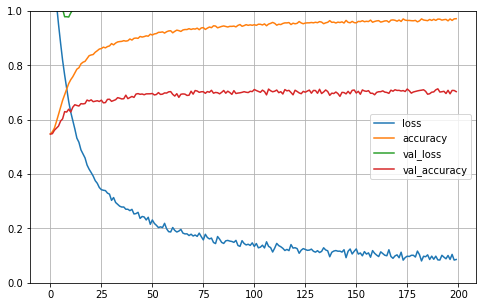

In [15]:
# Plot cost and accuracy, copied from Titantic_2
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [30]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
samuel_900.save('saved_model/samuel_900')
!zip -r /content/saved_model.zip /content/saved_model

INFO:tensorflow:Assets written to: saved_model/samuel_900/assets
  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/samuel_900/ (stored 0%)
  adding: content/saved_model/samuel_900/assets/ (stored 0%)
  adding: content/saved_model/samuel_900/variables/ (stored 0%)
  adding: content/saved_model/samuel_900/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/saved_model/samuel_900/variables/variables.index (deflated 59%)
  adding: content/saved_model/samuel_900/saved_model.pb (deflated 90%)


# User-Interface Loop

In [17]:
# Model initialization from notebook virtual machine save
samuel_900 = tf.keras.models.load_model('saved_model/samuel_900')
samuel_900.summary()     # check its architecture
eval_score, eval_accuracy = samuel_900.evaluate(test_data, test_labels, verbose=2)
print(f'\n\nRestored model score: {eval_score}')
print(f'Restored model accuracy: {eval_accuracy}')

Model: "SAMUEL_900"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 116)               13572     
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 100)               11700     
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 80)                8080      
_________________________________________________________________
hidden_layer_4 (Dense)       (None, 80)                6480      
_________________________________________________________________
hidden_layer_5 (Dense)       (None, 90)                7290      
_________________________________________________________________
hidden_layer_6 (Dense)       (None, 50)                4550      
_________________________________________________________________
output_layer (Dense)         (None, 7)                 3

In [28]:
def percent_change(old: float, new: float):
    if old == 0.0:
        old = 0.1
    return (new - old) / old


def unix_after_bdays(date: datetime, bdays: int) -> int:
    date = datetime.today() - BDay(bdays)
    return (date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


def get_sample_input(ticker_symbol: str, days_since_last: int=0):
    # set days_since_last to 0 for future predictions, pred_delta_t for historical validation
    raw_sample_input = []
    start_date = unix_after_bdays(datetime.today(), days_since_last+365)
    since_last = unix_after_bdays(datetime.today(), days_since_last)
    for ti in timeperiod_tis:
        for sml_period in sml_period_lengths:
            ti_data = fc.technical_indicator(ticker_symbol, 'D', start_date, since_last, indicator=ti, indicator_fields={'timeperiod': sml_period})
            if ti == 'aroon':
                ti_data = ti_data['aroonup'][-1] - ti_data['aroondown'][-1]
            else:
                ti_data = ti_data[ti][-1]
            raw_sample_input.append(ti_data)
            sleep(api_call_time_buffer) # api call buffer
    
    for ti in no_timeperiod_ti_columns:
        ti_data = fc.technical_indicator(ticker_symbol, 'D', start_date, since_last, indicator=ti)
        if ti == 'macd':
            ti_data = ti_data['macdHist'][-1]
        else:
            ti_data = ti_data[ti][-1]
        raw_sample_input.append(ti_data)
        sleep(api_call_time_buffer) # api call buffer

    volume = fc.stock_candles(ticker_symbol, 'D', start_date, since_last)['v'][-1]
    raw_sample_input.append(volume)

    # NOTE: Temporary band-aid for until this can be automated with a stock-index API
    # Be careful, there's no user-input safeguards here for simplicity and laziness lol
    # for market_name in market_indices:
    #     current_price = float(input(f'\t{market_name}\'s current price: ').replace(',', ''))
    #     for period in sml_period_lengths:
    #         period_price = float(input(f'\t\t{market_name}\'s price {period} periods ago: ').replace(',', ''))
    #         raw_sample_input.append(percent_change(period_price, current_price))
    
    # This is the market index data readout for 3/25/2021
    raw_sample_input += [12961.89, 6184470000, 13398.67, 13597.97, 13201.98,  # Nasdaq Composite
                         2134.27, 4766990000, 2338.54, 2284.38, 2202.98, # Russell 2000
                         3889.14, 3939.34, 3925.43, 3824.68, # S&P 500 (does NOT have the volume input feature)
                         32420.06, 3993900, 32485.59, 31961.86, 31097.97] # Dow Jones

    return np.array(raw_sample_input)

In [ ]:
loop_title = 'SAMUEL_900 Purchase-Action UI Loop'
equal_sign_separator = '=' * len(loop_title)
print(f'{loop_title}\n{equal_sign_separator}')
print('Hi! I\'m Samuel! I give you my predicted likelihoods for whether you should buy, sell, or hold stock for tickers you request!')
print('I specialize in tickers in the information technology sector. I was trained using these symbols:')
for ticker_symbol in training_symbols:
    print(f'\t{ticker_symbol}')
print()

print('Here are the latest confidence-magnitudes for buy and sell actions:')
for thresh, label in thresh_vec.items():
    print(f'{label:<15}{int(thresh)}%')     # assumes that the confidence magnitudes don't have a thousandth place
print()
print(f'My latest validation accuracy was {round(eval_accuracy*100.0, 2)}%. Random change is {round(100.0/len(output_columns), 2)}\n')
exit_code = 'exit0'
print('Enter your ticker symbols (not case-sensitive), separated by spaces. More tickers takes more time due to my API-call limits.\n')
final_msg = f'When you\'re finished, just enter \'{exit_code}\' to exit and put me to sleep.'
equal_sign_separator = '=' * len(final_msg)
print(f'{final_msg}\n{equal_sign_separator}\n\n')

output_col_index = -1
def next_output_col():
    global output_col_index
    if output_col_index < len(output_columns)-1:
        output_col_index += 1
    else:
        output_col_index = 0
    return output_columns[output_col_index]

while True:
    symbols = input('What ticker symbols would you like me to analyze?\n').split()
    symbols = list(dict.fromkeys(symbols))      # remove any duplicates
    print()
    if len(symbols) == 1 and symbols[0] == exit_code:
        break
    for symbol in symbols:
        symbol = symbol.upper()
        # try:
        #     raw_input_data = get_sample_input(symbol)
        # except:
        #     print('Something went wrong. You probably entered an unknown ticker symbol...\n')
        #     continue
        raw_input_data = get_sample_input(symbol)
        print(f'{symbol} profitable-action likelihoods:')
        symbol_input_data = scaler.transform(raw_input_data.reshape(1, -1))
        prediction = samuel_900.predict(symbol_input_data)[0] * 100.0
        for prob in prediction:
            prob = str(round(prob, 2)) + '%'
            print(f'{prob:<15}{next_output_col()}')
        print()
print('Goodbye.')

SAMUEL_900 Purchase-Action UI Loop
Hi! I'm Samuel! I give you my predicted likelihoods for whether you should buy, sell, or hold stock for tickers you request!
I specialize in tickers in the information technology sector. I was trained using these symbols:
	LSCC
	A
	AMZN
	FB
	CSCO
	AAPL
	MSFT
	GOOGL
	ORCL
	SAP
	IBM

Here are the latest confidence-magnitudes for buy and sell actions:
Fair           0%
Moderate       0%
Strong         0%

My latest validation accuracy was 70.33%. Random change is 14.29

Enter your ticker symbols (not case-sensitive), separated by spaces. More tickers takes more time due to my API-call limits.

When you're finished, just enter 'exit0' to exit and put me to sleep.


What ticker symbols would you like me to analyze?
aapl

